In [5]:
import numpy as np
import pandas as pd
import datetime as dt

import pandas_datareader as pdr
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from scipy import stats

import warnings
warnings.simplefilter("ignore")

In [6]:
#AT&T
#dataraw = pd.read_csv("HW1_Raw_ATnT.csv")
#JP Morgan
dataraw = pd.read_csv("HW1_Raw_JPMC.csv")
#Exxon
#dataraw = pd.read_csv("HW1_Raw_Exxon.csv")

In [7]:
#Pull Risk Free Rate Data
data_rfr = pdr.get_data_fred('GS2')
data_rfr.reset_index(inplace = True)
data_rfr.columns = ["Date", "RFR"]

In [8]:
#Data Handling
dataraw.columns = ["PERMNO", "Date", "DeclarationDate", "PayDate", "RecDate", "DistCode", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]
dataraw["Date"] = pd.to_datetime(dataraw["Date"], format='%Y%m%d')
dataraw["DeclarationDate"] = pd.to_datetime(dataraw["DeclarationDate"], format='%Y%m%d')
dataraw["PayDate"] = pd.to_datetime(dataraw["PayDate"], format='%Y%m%d')
dataraw["RecDate"] = pd.to_datetime(dataraw["RecDate"], format='%Y%m%d')
dataraw = dataraw[pd.to_numeric(dataraw['HolPerReturn'], errors='coerce').notnull()]
dataraw['HolPerReturn'] = pd.to_numeric(dataraw['HolPerReturn'])
dataraw = dataraw[pd.to_numeric(dataraw['MarketReturn'], errors='coerce').notnull()]
dataraw['MarketReturn'] = pd.to_numeric(dataraw['MarketReturn'])
dataraw = dataraw.sort_values(by='Date', ascending=True)

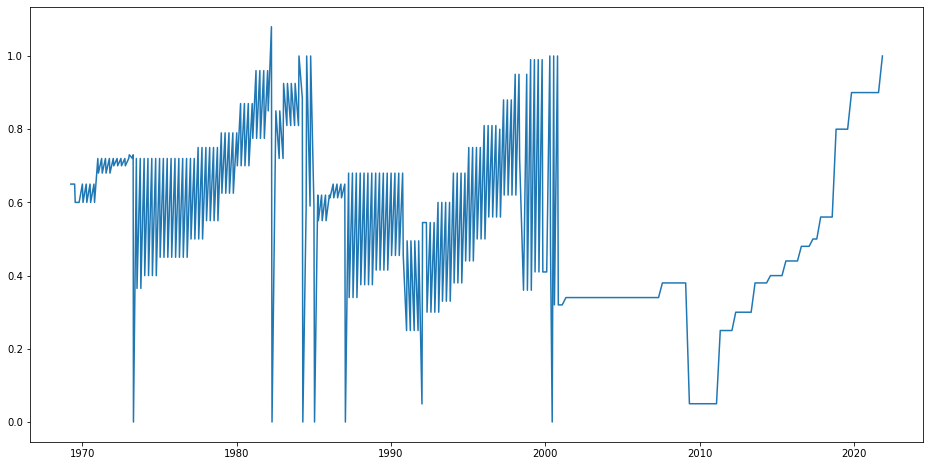

In [9]:
#Create Chart for Dividend amount
data_cht = dataraw.drop_duplicates(subset=['PayDate'], keep='last').copy()
data_cht = data_cht.sort_values(by='PayDate', ascending=True)
data_cht = data_cht.loc[:,["Date", "DeclarationDate", "PayDate", "RecDate", "DivAmount", "Price", "Volume", "HolPerReturn", "MarketReturn"]].dropna().reset_index(drop = True).copy()
plt.figure(figsize = (16,8))
plt.plot(data_cht["PayDate"], data_cht["DivAmount"])
plt.show()

In [10]:
#Separate dataset for return calculation
data_ret = dataraw.loc[:,["Date", "Price", "Volume", "HolPerReturn", "MarketReturn"]].dropna().reset_index(drop = True).copy()
data_ret['RFR'] = data_ret['Date'].apply(lambda x: data_rfr[data_rfr['Date']>x]["RFR"].reset_index(drop=True)[0])
data_ret

,Date,Price,Volume,HolPerReturn,MarketReturn,RFR
0,1969-03-06,64.37500,4400.0,-0.001938,-0.011575,1.24
1,1969-03-07,63.75000,2300.0,-0.009709,-0.001681,1.24
2,1969-03-10,62.00000,5700.0,-0.017255,0.003712,1.24
3,1969-03-11,63.00000,7800.0,0.016129,0.004220,1.24
4,1969-03-12,63.37500,7800.0,0.005952,-0.002623,1.24
...,...,...,...,...,...,...
21343,2021-12-27,158.16000,6189234.0,0.005723,0.012050,0.98
21344,2021-12-28,158.64000,6342743.0,0.003035,-0.002435,0.98
21345,2021-12-29,158.56000,6398927.0,-0.000504,0.000556,0.98
21346,2021-12-30,158.48000,6948171.0,-0.000505,-0.000982,0.98


In [11]:
datelist = np.sort(data_ret["Date"].unique())

In [12]:
datelist

array(['1969-03-06T00:00:00.000000000', '1969-03-07T00:00:00.000000000',
       '1969-03-10T00:00:00.000000000', ...,
       '2021-12-29T00:00:00.000000000', '2021-12-30T00:00:00.000000000',
       '2021-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [31]:
def find_estimation_window(decl_date, diff):
    try:
        idx = np.where(datelist==decl_date)[0][0]
        return datelist[idx + diff]
    except:
        np.nan

In [33]:
find_estimation_window(dividend_meta.index[i], 11)

In [25]:
dividend_meta

,EstimationWindowSt,EstimationWindowEnd,EventWindowSt,EventWindowEnd,alpha,beta
DeclarationDate,,,,,,
1969-02-27,1968-08-28 09:05:24,1969-02-16,1969-02-17,1969-03-09,NaN,NaN
1969-05-23,1968-11-21 09:05:24,1969-05-12,1969-05-13,1969-06-02,NaN,NaN
1969-06-04,1968-12-03 09:05:24,1969-05-24,1969-05-25,1969-06-14,NaN,NaN
1969-09-03,1969-03-04 09:05:24,1969-08-23,1969-08-24,1969-09-13,NaN,NaN
1969-11-26,1969-05-27 09:05:24,1969-11-15,1969-11-16,1969-12-06,NaN,NaN
...,...,...,...,...,...,...
2020-09-15,2020-03-16 09:05:24,2020-09-04,2020-09-05,2020-09-25,NaN,NaN
2020-12-08,2020-06-08 09:05:24,2020-11-27,2020-11-28,2020-12-18,NaN,NaN
2021-03-16,2020-09-14 09:05:24,2021-03-05,2021-03-06,2021-03-26,NaN,NaN


In [34]:
dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,11))

0            NaT
1     1969-06-10
2     1969-06-19
3     1969-09-18
4     1969-12-12
         ...    
330   2020-09-30
331   2020-12-23
332   2021-03-31
333   2021-06-02
334   2021-10-06
Name: DeclarationDate, Length: 335, dtype: datetime64[ns]

In [39]:
dividend_meta = dataraw.drop_duplicates(subset=['DeclarationDate'], keep='last').reset_index(drop=True)[['DeclarationDate']].dropna().copy()
dividend_meta.insert(1,'EstimationWindowSt', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-150)))
dividend_meta.insert(2,'EstimationWindowEnd', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-11)))
dividend_meta.insert(3,'EventWindowSt', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,-10)))
dividend_meta.insert(4,'EventWindowEnd', dividend_meta['DeclarationDate'].apply(lambda x: find_estimation_window(x,10)))
dividend_meta = dividend_meta.set_index('DeclarationDate', drop=True)
dividend_meta.dropna(inplace = True)

In [15]:
#Set index
i = 330

In [15]:
dec_date = dividend_meta.index[i]
est_st = dividend_meta['EstimationWindowSt'][i]
est_ed = dividend_meta['EstimationWindowEnd'][i]
evt_st = dividend_meta['EventWindowSt'][i]
evt_ed = dividend_meta['EventWindowEnd'][i]
data_est = data_ret[(data_ret['Date'] >= est_st) & (data_ret['Date'] <= est_ed)].reset_index(drop=True).copy()
data_evt = data_ret[(data_ret['Date'] >= evt_st) & (data_ret['Date'] <= evt_ed)].reset_index(drop=True).copy()

print('The mean return of the stock during estimation period is:', round(data_est['HolPerReturn'].mean()*100,3), '%')
print('The mean return of the market during estimation period is:', round(data_est['MarketReturn'].mean()*100,3), '%')

print("The standard deviation of the stock's return during estimation period is:", round(data_est['HolPerReturn'].std()*100,3), '%')
print("The standard deviation of the market's return during estimation period is:", round(data_est['MarketReturn'].std()*100,3), '%')

#print("The variance of the error term is:", round(sum((data_est['HolPerReturn'] - alpha - beta * data_est['MarketReturn'])**2)/len(data_est['HolPerReturn']), 9))

The mean return of the stock during estimation period is: 0.207 %
The mean return of the market during estimation period is: 0.335 %
The standard deviation of the stock's return during estimation period is: 3.46 %
The standard deviation of the market's return during estimation period is: 2.056 %


In [34]:
MktModel = sm.OLS(data_est["HolPerReturn"].astype(float), sm.add_constant(data_est['MarketReturn'].astype(float))).fit()
MktModel_alpha = MktModel.params[0]
MktModel_beta = MktModel.params[1]
MktModel_AR = data_evt["HolPerReturn"] - MktModel_alpha - MktModel_beta * data_evt["MarketReturn"]
MktModel_CAR = MktModel_AR.cumsum()

data_evt = data_ret[(data_ret['Date'] >= evt_st) & (data_ret['Date'] <= evt_ed)].reset_index(drop=True).copy()
CAPMModel = sm.OLS(data_evt["HolPerReturn"].astype(float) - data_evt["RFR"].astype(float), sm.add_constant(data_evt['MarketReturn'].astype(float) - data_evt["RFR"].astype(float))).fit()
CAPMModel_beta = CAPMModel.params[0]
CAPMModel_AR = data_evt["HolPerReturn"] - data_evt["RFR"] - CAPMModel_beta * (data_evt['MarketReturn'] - data_evt["RFR"])
CAPMModel_CAR = CAPMModel_AR.cumsum()

MktAER_AR = data_evt["HolPerReturn"] - data_evt['MarketReturn']
MktAER_CAR = MktAER_AR.cumsum()

MeanAER_AR = data_evt["HolPerReturn"] - data_est['HolPerReturn'].mean()
MeanAER_CAR = MeanAER_AR.cumsum()

In [40]:
AR_Table = pd.DataFrame()
AR_Table['MarketModel'] = MktModel_AR
AR_Table['CAPMModel'] = CAPMModel_AR
AR_Table['MktAdjERModel'] = MktAER_AR
AR_Table['MeanAdjERModel'] = MeanAER_AR

CAR_Table = pd.DataFrame()
CAR_Table['MarketModel'] = MktModel_AR
CAR_Table['CAPMModel'] = CAPMModel_CAR
CAR_Table['MktAdjERModel'] = MktAER_CAR
CAR_Table['MeanAdjERModel'] = MeanAER_CAR

In [42]:
AR_Table

,MarketModel,CAPMModel,MktAdjERModel,MeanAdjERModel
0,0.003712,-0.056791,-0.007976,-0.036844
1,-0.014753,-0.046271,-0.010335,0.007440
2,0.013053,-0.040463,0.005247,-0.012378
3,0.015108,-0.028858,0.012609,0.010353
4,-0.004450,-0.038720,-0.001561,0.011784
5,-0.035977,-0.076463,-0.036542,-0.033199
6,0.010898,-0.034907,0.007377,0.002162
7,0.001586,-0.047153,-0.003565,-0.013502
8,0.012175,-0.037158,0.006694,-0.004199
9,-0.011645,-0.063268,-0.018399,-0.032978


In [41]:
CAR_Table

,MarketModel,CAPMModel,MktAdjERModel,MeanAdjERModel
0,0.003712,-0.056791,-0.007976,-0.036844
1,-0.014753,-0.103062,-0.018311,-0.029403
2,0.013053,-0.143525,-0.013064,-0.041781
3,0.015108,-0.172383,-0.000455,-0.031428
4,-0.004450,-0.211104,-0.002016,-0.019643
5,-0.035977,-0.287567,-0.038558,-0.052842
6,0.010898,-0.322474,-0.031181,-0.050680
7,0.001586,-0.369626,-0.034746,-0.064181
8,0.012175,-0.406784,-0.028052,-0.068380
9,-0.011645,-0.470052,-0.046451,-0.101358


In [12]:
data_est

,Date,Price,Volume,HolPerReturn,MarketReturn,RFR
0,2020-03-17,93.76,35239844.0,0.061114,0.053074,0.22
1,2020-03-18,83.89,41525568.0,-0.105269,-0.059610,0.22
2,2020-03-19,85.30,32175060.0,0.016808,0.014319,0.22
3,2020-03-20,83.50,30150823.0,-0.021102,-0.037156,0.22
4,2020-03-23,79.03,32536580.0,-0.053533,-0.026878,0.22
...,...,...,...,...,...,...
116,2020-08-31,100.19,14219441.0,-0.025105,-0.001560,0.13
117,2020-09-01,100.14,11602053.0,-0.000499,0.008489,0.15
118,2020-09-02,101.65,14475673.0,0.015079,0.012121,0.15
119,2020-09-03,101.33,23281235.0,-0.003148,-0.033998,0.15


In [13]:
data_evt

,Date,Price,Volume,HolPerReturn,MarketReturn,RFR
0,2020-09-08,99.92,22108612.0,-0.034776,-0.026800,0.15
1,2020-09-09,100.87,13434024.0,0.009508,0.019843,0.15
2,2020-09-10,99.83,15922793.0,-0.010310,-0.015557,0.15
3,2020-09-11,101.07,13784342.0,0.012421,-0.000188,0.15
4,2020-09-14,102.47,19017373.0,0.013852,0.015413,0.15
5,2020-09-15,99.28,23682973.0,-0.031131,0.005411,0.15
6,2020-09-16,99.70,19284239.0,0.004230,-0.003147,0.15
7,2020-09-17,98.56,18290104.0,-0.011434,-0.007869,0.15
8,2020-09-18,98.35,20121579.0,-0.002131,-0.008825,0.15
9,2020-09-21,95.31,28378768.0,-0.030910,-0.012511,0.15
